In [1]:
import os 
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import powerlaw

random.seed(133)
np.random.seed(133)

def weighted_average(history, decay=0.8):
    weights = [decay**i for i in range(len(history)-1, -1, -1)]
    weights = np.array(weights) / sum(weights)
    return np.sum(np.array(history) * weights)

def compute_avalanches(series, delta=0.01):
    return np.diff(series)[np.diff(series) > delta]


class Household(Agent):
    def __init__(self, unique_id, model, P, C0, alpha, bin_id):
        super().__init__(unique_id, model)
        self.P, self.C0, self.alpha, self.bin_id = P, C0, alpha, bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = model.logit
        self.memory_length = model.memory_length
        self.rho_history = deque(maxlen=self.memory_length)
        self.deltaC_history = deque(maxlen=self.memory_length)
        self.decay = model.decay
        self.s = self.random.random() < 0.5
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0
        self.rho = 0.0
        self.deltaC = 0.0

    def step(self):
        if self.rho_history:
            self.hat_rho = weighted_average(self.rho_history, decay=self.decay)
        if self.deltaC_history:
            self.hat_deltaC = weighted_average(self.deltaC_history, decay=self.decay)
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = U_R > U_N

    def advance(self):
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        self.rho = np.mean([self.model.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
        if self.s:
            self.model.bins[self.bin_id].Q_m += 1
        self.rho_history.append(self.rho)
        self.deltaC_history.append(self.deltaC)

class Bin(Agent):
    def __init__(self, unique_id, model, K_m, pos):
        super().__init__(unique_id, model)
        self.K_m, self.Q_m, self.pos = K_m, 0, pos
    def step(self): pass
    def advance(self): pass

class RecyclingModel(Model):
    def __init__(self, N=100, L=10, M=9, k=4, beta=0.1, delta=0.5, c=0.3, kappa=0.05,
                 epsilon=0.05, alpha=0.4, K_default=10, memory_length=10,
                 logit=False, lambda_param=1.0, seed=133, activation='random', decay=0.8):
        super().__init__()

        # Store model parameters first so they're available to agents
        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.num_agents, self.grid_size, self.num_bins = N, L, M
        self.delta, self.c, self.kappa, self.epsilon = delta, c, kappa, epsilon
        self.alpha, self.K_default = alpha, K_default
        self.memory_length = memory_length
        self.logit = logit
        self.lambda_param = lambda_param
        self.decay = decay

        # Network and grid
        self.G = nx.watts_strogatz_graph(n=N, k=k, p=beta, seed=self.random.randint(1e9))
        self.net = NetworkGrid(self.G)
        self.grid = MultiGrid(width=L, height=L, torus=False)
        self.schedule = SimultaneousActivation(self)

        # Create bins
        self.households, self.bins = {}, {}
        bin_positions = [(x, y) for x in [2, 5, 8] for y in [2, 5, 8]]
        for m, (x_m, y_m) in enumerate(bin_positions):
            bin_id = N + m
            bin_agent = Bin(bin_id, self, K_default, (x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        # Assign household coordinates
        coords = [(i, j) for i in range(L) for j in range(L)][:N]
        P_vals = np.random.rand(N)
        champions = self.random.choice(N, size=int(epsilon * N), replace=False)
        for i in champions:
            P_vals[i] = 2.0

        # Create households
        for i in range(N):
            x_i, y_i = coords[i]
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos)) for m in self.bins]
            bin_id = int(np.argmin(dists))
            C0_i = 0.0 if i in champions else c + kappa * dists[bin_id]
            agent = Household(i, self, P_vals[i], C0_i, 1.0 if i in champions else alpha, bin_id)
            self.households[i] = agent
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords[i])
            self.net.place_agent(agent, i)

        # Initialize social info
        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            agent.rho = np.mean([self.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
            agent.deltaC = 0.0
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0

        # Data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho": lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins": lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m)
            },
            agent_reporters={"Strategy": lambda a: a.s if isinstance(a, Household) else None}
        )

    def step(self):
        for b in self.bins.values():
            b.Q_m = 0
        self.schedule.step()
        for agent in self.households.values():
            bin_agent = self.bins[agent.bin_id]
            agent.deltaC = self.delta * max(0, bin_agent.Q_m - bin_agent.K_m)
        self.datacollector.collect(self)

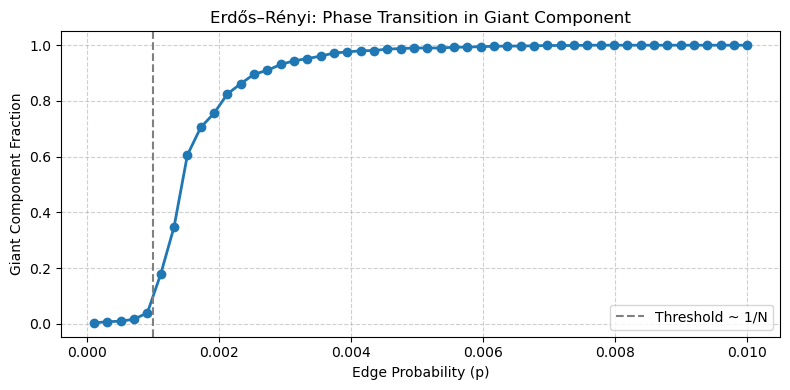

In [10]:
# Re-import necessary libraries due to kernel reset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Parameters
N = 1000  # Larger network
p_vals = np.linspace(0.0001, 0.01, 50)  # ER edge probability
giant_fractions = []

# Compute giant component fraction for each p
for p in p_vals:
    G = nx.erdos_renyi_graph(N, p, seed=42)
    if len(G) == 0 or not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len, default=[])
        giant_fraction = len(largest_cc) / N
    else:
        giant_fraction = 1.0
    giant_fractions.append(giant_fraction)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(p_vals, giant_fractions, marker='o', lw=2)
plt.axvline(x=1/N, color='gray', linestyle='--', label='Threshold ~ 1/N')
plt.xlabel("Edge Probability (p)")
plt.ylabel("Giant Component Fraction")
plt.title("Erdős–Rényi: Phase Transition in Giant Component")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


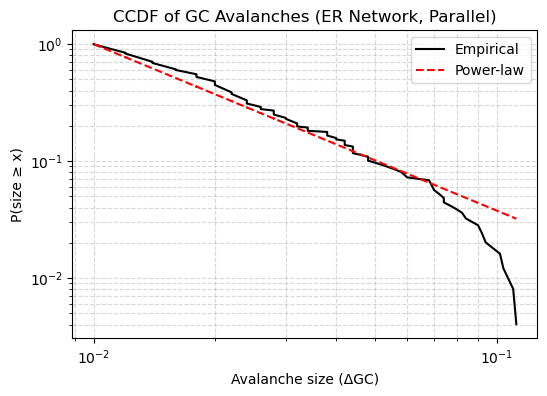

({'alpha': 2.4232309603085493,
  'xmin': 0.01,
  'ks': 0.119219534915534,
  'R_ln': -3.337236353111802,
  'p_ln': 0.10591311990778847,
  'R_exp': 13.430158563390176,
  'p_exp': 0.09052006783286282},
 [0.013999999999999999,
  0.05,
  0.020000000000000004,
  0.05399999999999999,
  0.07,
  0.043999999999999984,
  0.016000000000000014,
  0.019999999999999962,
  0.01200000000000001,
  0.043999999999999984,
  0.014000000000000012,
  0.04199999999999998,
  0.01200000000000001,
  0.02200000000000002,
  0.010000000000000009,
  0.020000000000000018,
  0.01200000000000001,
  0.014000000000000012,
  0.01200000000000001,
  0.01200000000000001])

In [2]:
# Re-import necessary modules due to environment reset
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw
from joblib import Parallel, delayed
import os

# Parameters
N = 500
num_trials = 10
p_vals = np.linspace(0.0005, 0.005, 200)


# Function to compute giant component series for one trial
def compute_gc_series_trial(N, p_vals, seed=None):
    rng = np.random.default_rng(seed)
    gc_series = []
    for p in p_vals:
        G = nx.erdos_renyi_graph(N, p, seed=int(seed) % (2**32))

        if len(G) == 0 or not nx.is_connected(G) and len(max(nx.connected_components(G), key=len)) == 1:
            gc_frac = 0.0
        else:
            gc_frac = len(max(nx.connected_components(G), key=len)) / N
        gc_series.append(gc_frac)
    return gc_series

# Run trials in parallel
all_gc_series = Parallel(n_jobs=-1)(
    delayed(compute_gc_series_trial)(N, p_vals, seed=i) for i in range(num_trials)
)

# Aggregate and compute avalanches
all_avalanches = []
for series in all_gc_series:
    aval = np.diff(series)
    aval = aval[aval > 0.01]
    all_avalanches.extend(aval)

# Fit power law
results = {}
if len(all_avalanches) >= 5:
    fit = powerlaw.Fit(all_avalanches, xmin=0.01, discrete=False)

    results = {
        "alpha": fit.power_law.alpha,
        "xmin": fit.power_law.xmin,
        "ks": fit.power_law.KS(),
        "R_ln": fit.distribution_compare('power_law', 'lognormal')[0],
        "p_ln": fit.distribution_compare('power_law', 'lognormal')[1],
        "R_exp": fit.distribution_compare('power_law', 'exponential')[0],
        "p_exp": fit.distribution_compare('power_law', 'exponential')[1],
    }

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label='Power-law')
    plt.xlabel("Avalanche size (ΔGC)")
    plt.ylabel("P(size ≥ x)")
    plt.title("CCDF of GC Avalanches (ER Network, Parallel)")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/er_gc_avalanches_powerlaw_parallel.png", dpi=300)
    plt.show()

results, all_avalanches[:20]  # return preview of avalanches


Assuming nested distributions


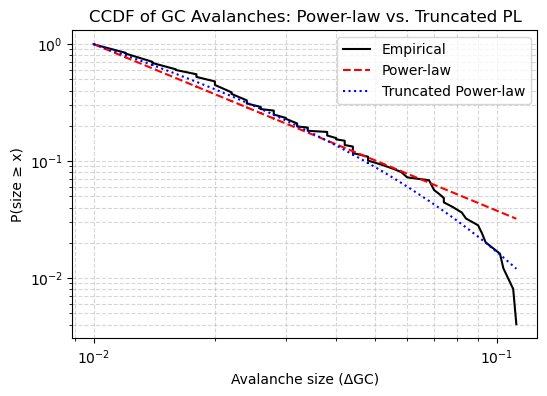

Results:
 {'alpha': 2.4232309603085493, 'xmin': 0.01, 'ks': 0.119219534915534, 'R_ln': -3.337236353111802, 'p_ln': 0.10591311990778847, 'R_exp': 13.430158563390176, 'p_exp': 0.09052006783286282, 'R_tpl': -5.231109181362753, 'p_tpl': 0.0012184087424454981, 'lambda_tpl': 14.95665836674133}


In [4]:
import powerlaw
import matplotlib.pyplot as plt
import os

# Fit power law (requires at least 5 data points)
if len(all_avalanches) >= 5:
    fit = powerlaw.Fit(all_avalanches, xmin=0.01, discrete=False, verbose=False)

    # Fit comparisons
    R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
    R_tpl, p_tpl = fit.distribution_compare('power_law', 'truncated_power_law')

    # Extract parameters
    results = {
        'alpha': fit.power_law.alpha,
        'xmin': fit.power_law.xmin,
        'ks': fit.power_law.KS(),
        'R_ln': R_ln,
        'p_ln': p_ln,
        'R_exp': R_exp,
        'p_exp': p_exp,
        'R_tpl': R_tpl,
        'p_tpl': p_tpl,
        'lambda_tpl': fit.truncated_power_law.parameter2,
    }

    # Plot CCDF
    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label='Power-law')
    fit.truncated_power_law.plot_ccdf(ax=ax, color='blue', linestyle=':', label='Truncated Power-law')
    plt.xlabel("Avalanche size (ΔGC)")
    plt.ylabel("P(size ≥ x)")
    plt.title("CCDF of GC Avalanches: Power-law vs. Truncated PL")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/er_gc_truncated_powerlaw_comparison.png", dpi=300)
    plt.show()

    print("Results:\n", results)
else:
    print("Not enough avalanche data to fit.")


In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import powerlaw

random.seed(133)
np.random.seed(133)


def weighted_average(history, decay=0.8):
    weights = [decay**i for i in range(len(history)-1, -1, -1)]
    weights = np.array(weights) / sum(weights)
    return np.sum(np.array(history) * weights)


def compute_avalanches(series, delta=0.01):
    return np.diff(series)[np.diff(series) > delta]


class Household(Agent):
    def __init__(self, unique_id, model, P, C0, alpha, bin_id):
        super().__init__(unique_id, model)
        self.P, self.C0, self.alpha, self.bin_id = P, C0, alpha, bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = model.logit
        self.memory_length = model.memory_length
        self.rho_history = deque(maxlen=self.memory_length)
        self.deltaC_history = deque(maxlen=self.memory_length)
        self.decay = model.decay
        self.s = self.random.random() < 0.5
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0
        self.rho = 0.0
        self.deltaC = 0.0

    def step(self):
        if self.rho_history:
            self.hat_rho = weighted_average(self.rho_history, decay=self.decay)
        if self.deltaC_history:
            self.hat_deltaC = weighted_average(self.deltaC_history, decay=self.decay)
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = U_R > U_N

    def advance(self):
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        self.rho = np.mean([self.model.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
        if self.s:
            self.model.bins[self.bin_id].Q_m += 1
        self.rho_history.append(self.rho)
        self.deltaC_history.append(self.deltaC)


class Bin(Agent):
    def __init__(self, unique_id, model, K_m, pos):
        super().__init__(unique_id, model)
        self.K_m, self.Q_m, self.pos = K_m, 0, pos

    def step(self): pass
    def advance(self): pass


class RecyclingModel(Model):
    def __init__(self, N=100, L=10, M=9, beta=0.1, delta=0.5, c=0.3, kappa=0.05,
                 epsilon=0.05, alpha=0.4, K_default=10, memory_length=10,
                 logit=False, lambda_param=1.0, seed=133, activation='random', decay=0.8):
        super().__init__()

        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.num_agents, self.num_bins = N, M
        self.delta, self.c, self.kappa, self.epsilon = delta, c, kappa, epsilon
        self.alpha, self.K_default = alpha, K_default
        self.memory_length = memory_length
        self.logit = logit
        self.lambda_param = lambda_param
        self.decay = decay

        # Dynamically determine grid size
        L = max(L, int(np.ceil(np.sqrt(N))))
        self.grid_size = L
        self.grid = MultiGrid(width=L, height=L, torus=False)

        # Create Erdős-Rényi network
        self.G = nx.erdos_renyi_graph(n=N, p=beta, seed=self.random.randint(1e9))
        self.net = NetworkGrid(self.G)
        self.schedule = SimultaneousActivation(self)

        # Create bins
        self.households, self.bins = {}, {}
        bin_positions = [(x, y) for x in np.linspace(2, L - 3, 3, dtype=int)
                               for y in np.linspace(2, L - 3, 3, dtype=int)]
        for m, (x_m, y_m) in enumerate(bin_positions[:M]):
            bin_id = N + m
            bin_agent = Bin(bin_id, self, K_default, (x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        # Assign household coordinates (ensure enough positions)
        coords = [(i, j) for i in range(L) for j in range(L)]
        if len(coords) < N:
            raise ValueError(f"Grid size {L}×{L} too small for {N} agents.")
        coords = coords[:N]

        # Assign pro-environmental preferences
        P_vals = np.random.rand(N)
        champions = self.random.choice(N, size=int(epsilon * N), replace=False)
        for i in champions:
            P_vals[i] = 2.0

        # Create households
        for i in range(N):
            x_i, y_i = coords[i]
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos)) for m in self.bins]
            bin_id = int(np.argmin(dists))
            C0_i = 0.0 if i in champions else c + kappa * dists[bin_id]
            agent = Household(i, self, P_vals[i], C0_i, 1.0 if i in champions else alpha, bin_id)
            self.households[i] = agent
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords[i])
            self.net.place_agent(agent, i)

        # Initialize local social info
        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            agent.rho = np.mean([self.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
            agent.deltaC = 0.0
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0

        # Data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho": lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins": lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m)
            },
            agent_reporters={"Strategy": lambda a: a.s if isinstance(a, Household) else None}
        )

    def step(self):
        for b in self.bins.values():
            b.Q_m = 0
        self.schedule.step()
        for agent in self.households.values():
            bin_agent = self.bins[agent.bin_id]
            agent.deltaC = self.delta * max(0, bin_agent.Q_m - bin_agent.K_m)
        self.datacollector.collect(self)



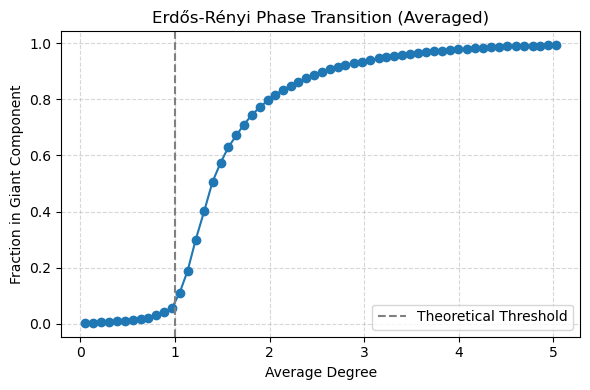

In [2]:
N = 1000
import numpy as np

# Fine sampling below and around the threshold
betas_low = np.linspace(0.001, 0.01, 30)   # gives avg_deg ~ 0.3 to ~1.0
betas_mid = np.linspace(0.011, 0.05, 40)   # gives avg_deg ~ 1.1 to ~5.0

betas = np.concatenate((betas_low, betas_mid))
  # tight around critical point
seeds = range(10)
avg_deg_range = np.linspace(0.05, 5, 60)  # choose step size or resolution
betas = avg_deg_range / (N - 1)

gc_means = []
avg_degrees = []

for beta in betas:
    gc_fractions = []
    degrees = []
    for seed in seeds:
        model = RecyclingModel(N=N, L=10, M=9, beta=beta, delta=0.7, c=0.3, kappa=0.05,
                               epsilon=0.05, alpha=0.5, K_default=10, memory_length=10,
                               logit=True, lambda_param=20, decay=0.8, activation='simultaneous', seed=seed)
        G = model.G
        avg_deg = sum(dict(G.degree()).values()) / N
        gc_size = len(max(nx.connected_components(G), key=len))
        gc_frac = gc_size / N
        gc_fractions.append(gc_frac)
        degrees.append(avg_deg)
    gc_means.append(np.mean(gc_fractions))
    avg_degrees.append(np.mean(degrees))


plt.figure(figsize=(6, 4))
plt.plot(avg_degrees, gc_means, marker='o')
plt.axvline(1, color='gray', linestyle='--', label='Theoretical Threshold')
plt.xlabel("Average Degree")
plt.ylabel("Fraction in Giant Component")
plt.title("Erdős-Rényi Phase Transition (Averaged)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("figures/gc_phase_transition_smooth.png", dpi=300)
plt.show()



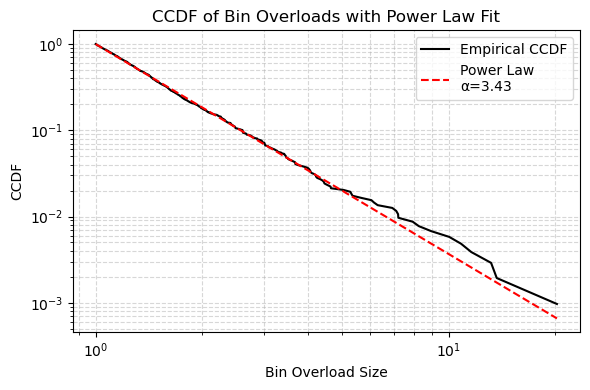

📊 Power Law Fit Results
Alpha (exponent): 3.4338
Xmin: 1.0000
KS Distance: 0.0166

Log-likelihood vs Lognormal: R = 0.005, p = 9.19e-01
Log-likelihood vs Exponential: R = 119.401, p = 2.36e-05


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# --- Simulated bin overloads (replace this with actual model data) ---
np.random.seed(42)
overload_sizes = []
for _ in range(10000):
    if np.random.rand() < 0.1:
        overload = np.random.pareto(a=2.5) + 1
        overload_sizes.append(overload)

# --- Clean data ---
overload_sizes = np.array(overload_sizes)
valid_overloads = overload_sizes[overload_sizes > 0.5]

# --- Power-law fit ---
fit = powerlaw.Fit(valid_overloads, xmin=1.0, discrete=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
ks_distance = fit.power_law.D

# --- Model comparison ---
R_lognormal, p_lognormal = fit.distribution_compare('power_law', 'lognormal')
R_exponential, p_exponential = fit.distribution_compare('power_law', 'exponential')

# --- Plot ---
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
fit.plot_ccdf(color='black', label="Empirical CCDF")
fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label=f"Power Law\nα={alpha:.2f}")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Bin Overload Size")
plt.ylabel("CCDF")
plt.title("CCDF of Bin Overloads with Power Law Fit")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Output Summary ---
print(f"📊 Power Law Fit Results")
print(f"Alpha (exponent): {alpha:.4f}")
print(f"Xmin: {xmin:.4f}")
print(f"KS Distance: {ks_distance:.4f}")
print(f"\nLog-likelihood vs Lognormal: R = {R_lognormal:.3f}, p = {p_lognormal:.2e}")
print(f"Log-likelihood vs Exponential: R = {R_exponential:.3f}, p = {p_exponential:.2e}")
